# Keras Model for Pneumonia Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from PIL import Image
from glob import iglob, glob
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as k
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [49]:
print(tf.__version__)

#tf.test.is_gpu_available()
print(tf.test.is_built_with_cuda())

k.clear_session()

os.getcwd()

2.0.0
True


'C:\\Users\\user\\Documents\\Spyder\\Projects\\Project-Chest_X-rays'

In [4]:
path = 'chest-xray-pneumonia/'
train_files = glob(os.path.join(path, 'train/', '*/*.jpeg'))
print(len(train_files))
test_files = glob(os.path.join(path, 'test', '*/*.jpeg'))
len(test_files)

5216


640

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, rotation_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_it = train_datagen.flow_from_directory('chest-xray-pneumonia/train/',
                        target_size=(156,156), color_mode='rgb',batch_size=16)

Found 5216 images belonging to 2 classes.


In [8]:
print(train_it.target_size)
print(train_it.class_indices)
print(train_it.color_mode)

(156, 156)
{'NORMAL': 0, 'PNEUMONIA': 1}
rgb


In [10]:
test_it = test_datagen.flow_from_directory(
    'chest-xray-pneumonia/test/', target_size=(156, 156), color_mode='rgb', shuffle=True,batch_size=16)

batch_x, batch_y = test_it.next()
print(batch_x.min())
print(batch_x.max())
print(batch_x.shape)

Found 640 images belonging to 2 classes.
0.0
1.0
(16, 156, 156, 3)


In [11]:
labels_2_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
idx_2_labels = {0:'NORMAL', 1:'PNEUMONIA'}

In [13]:
label_categories=['NORMAL','PNEUMONIA']
data=dict()
labels={}
size=(156,156)
train_lab,test_lab=[],[]
for a in ['test']:
    files,lab=[],[]
    for i,cat in enumerate(label_categories):
        for f in iglob(os.path.join(path,a,cat,'*.jpeg')):
            files.append(np.array(Image.open(f).resize(size,Image.ANTIALIAS).convert('RGB')))
            lab.append(i)          
    data[a]=np.array(files)
    labels[a]=np.array(lab)
       
print(data['test'].shape)    
print(labels['test'].shape)

(640, 156, 156, 3)
(640,)


In [14]:
#labels_counts
x_test,y_test_=data['test']/255.,labels['test']
rand_idx=np.random.randint(0,len(x_test),size=len(x_test))
y_test_=y_test_[rand_idx]; y_test_
x_test=x_test[rand_idx]
print(np.array(x_test).shape)
y_test_=np.array(y_test_)
y_test=to_categorical(y_test_)

(640, 156, 156, 3)


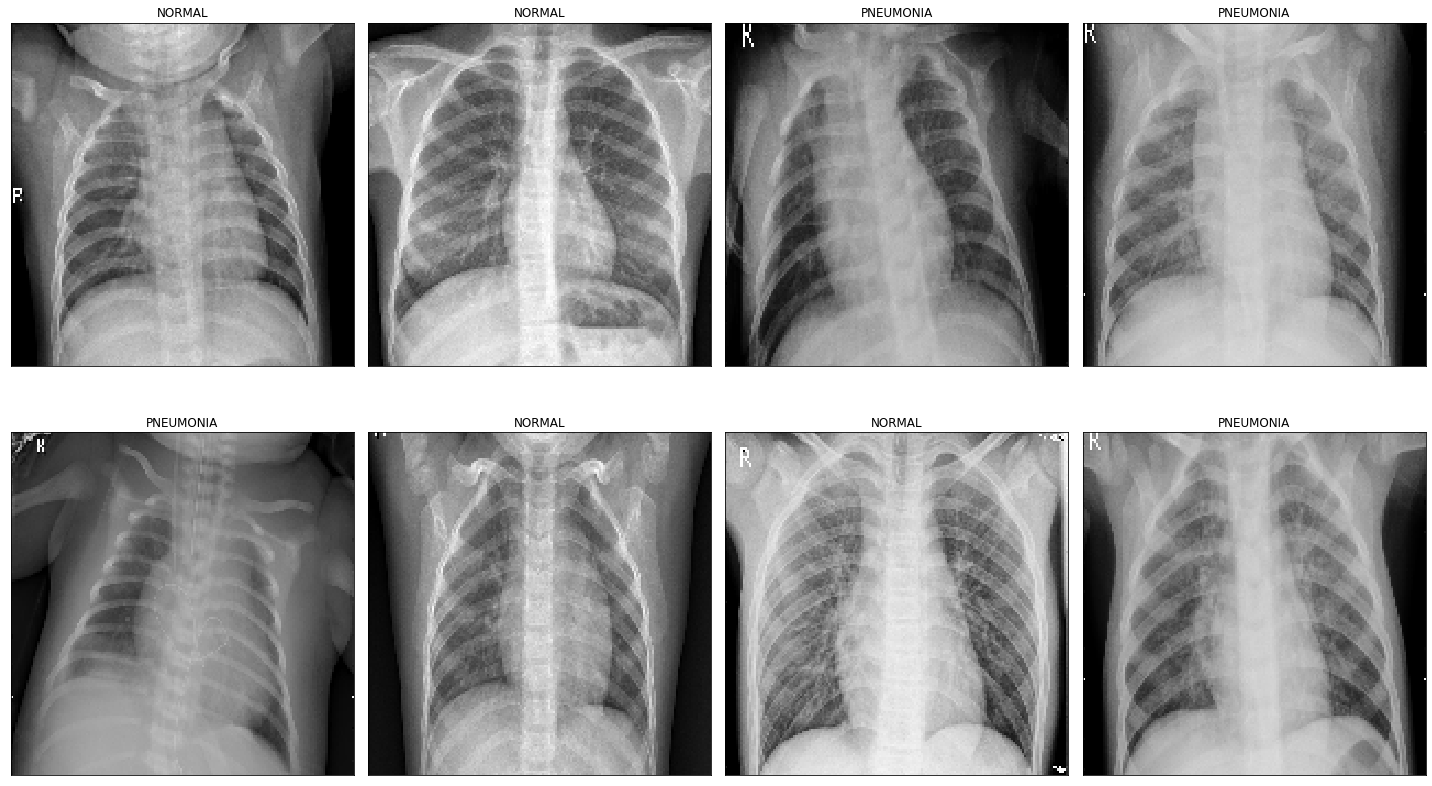

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12), subplot_kw={
                         'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(batch_x[i],cmap='gray')
    ax.set_title(idx_2_labels[np.argmax(batch_y[i])])
plt.tight_layout()

In [26]:
def create_model(image_shape,num_classes):
    num_classes = num_classes
    image_shape=image_shape

    base_model = ResNet50V2(weights='imagenet', include_top=False,
                      input_shape=image_shape)

    base_model.summary()
    base_model.trainable=False
    #for layer in base_model.layers[:200]:
    #    layer.trainable=False

    x=base_model.output
    x=Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [27]:
num_classes = 2
image_shape = batch_x.shape[1:]
model = create_model(image_shape,num_classes)
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156, 156, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 162, 162, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 78, 78, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 80, 80, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156, 156, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 162, 162, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 78, 78, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 80, 80, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [29]:

def train_generator(model,train_it,valid_it,save_dir):
    
    model_name = 'model2-{epoch:03d}-{val_accuracy:.2f}.h5'
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    filepath = os.path.join(save_dir, model_name)
    
    checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
    early_stop = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=3, mode='min')
    lr_reducer=ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,
                                 monitor='val_acc',min_lr=0.5e-06,verbose=1)
    callbacks = [lr_reducer,early_stop,checkpoint]
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    
    
    model.fit_generator(train_it,validation_data=valid_it,epochs=10,callbacks=callbacks)


In [33]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
print(save_dir)

train_generator(model,train_it,test_it,save_dir)

C:\Users\user\Documents\Spyder\Projects\Project-Chest_X-rays\saved_models


In [36]:
model_loc='model2-006-0.89.h5'
model=load_model(os.path.join(save_dir,model_loc))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156, 156, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 162, 162, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 78, 78, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 80, 80, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [40]:
loss,acc=model.evaluate(x_test,y_test,batch_size=16)
print(loss)
print(acc)

1.3680706334050796
0.9015625


In [44]:
y_pred=model.predict(x_test,batch_size=16)
y_pred=np.argmax(y_pred,axis=1)
pred_class,actual_class=[],[]
for i in range(len(y_pred)):
    pred_class.append(idx_2_labels[y_pred[i]])
    actual_class.append(idx_2_labels[y_test_[i]])


In [45]:
acc=accuracy_score(pred_class,actual_class)
print('\nAccuracy_Score....\n\t{} %'.format(np.round(acc*100,4)))

cm=confusion_matrix(actual_class,pred_class)
print('\nConfusion_matrix.....\n',cm)



Accuracy_Score....
	90.1562 %

Confusion_matrix.....
 [[208  36]
 [ 27 369]]


In [46]:
precision=cm[0,0]/(cm[0,0]+cm[1,0])
recall=cm[0,0]/(cm[0,0]+cm[0,1])
print('\nPrecsion_Score ....\n\t',np.round(precision,4))
print('\nRecall_Score.....\n\t',np.round(recall,4))


Precsion_Score ....
	 0.8851

Recall_Score.....
	 0.8525


In [47]:
f1=2*precision*recall/(precision+recall)
print('\nF1_Score.....\n\t',np.round(f1,4))



F1_Score.....
	 0.8685
